# 1 . Thư viện

In [2]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from vnstock.explorer.vci.financial import Finance
import pandas as pd


# 2. Function

# 3. Import data

In [31]:
#list cổ phiếu thuộc ngành sản xuất và midcap
list_stock=['ASM', 'CII', 'BWE', 'ANV', 'CTD', 'CRE', 'CMG', 'AAA', 'CTR']

#create một date-table rỗng
df_result=pd.DataFrame()
for stock in list_stock: #cho chạy stock chạy qua từng biến trong list_stock
    report = Finance(symbol=stock,period='quarter' )   # gán dữ liệu vào report ; Finance : một loại truy xuất từ các bài báo : symbol : tham số đại diện cho mã cổ phiếu, period : xác định kỳ của báo cáo tài chính là theo quý )
    data_B_sheet=report.balance_sheet(lang='vi')
    data_IS=report.income_statement(lang='vi')

    data=data_B_sheet.merge(data_IS,how='inner',on=['CP','Năm','Kỳ'])
    
    df_result=pd.concat([df_result,data])
    df_result.reset_index(drop=True,inplace=True)

df_result.to_csv('./data.csv',index=False)

In [73]:
data=pd.read_csv('./data.csv')

# 4. Processing data

# 5. Variable expansion

In [94]:
data['DER']=data['NỢ PHẢI TRẢ (Tỷ đồng)']/data['TỔNG CỘNG NGUỒN VỐN (Tỷ đồng)']
data['ROE']=data['Lợi nhuận thuần']/data['TỔNG CỘNG NGUỒN VỐN (Tỷ đồng)']
data['EV']=data['TỔNG CỘNG TÀI SẢN (Tỷ đồng)']-data['NỢ PHẢI TRẢ (Tỷ đồng)']-data['Tiền và tương đương tiền (Tỷ đồng)']
data['MVA']=data['EV']-data['Vốn góp của chủ sở hữu (Tỷ đồng)']
data['SIZE']= np.log(data['TỔNG CỘNG TÀI SẢN (Tỷ đồng)'])
data['ROA']=data['Lợi nhuận thuần']/data['TỔNG CỘNG TÀI SẢN (Tỷ đồng)'] 


In [84]:
#Bien muc tieu
data.sort_values(['CP','Năm','Kỳ'],inplace=True)
data['LAG_MVA']=data.groupby('CP')['MVA'].shift(-1)
data['target']=data['LAG_MVA']-data['MVA']

In [97]:
data_train=data[['DER','ROE','MVA','SIZE','ROA','target']].copy()
data_train.dropna(axis=0,how='any',inplace=True)

# 6 Train model
> Cái cần quan tâm ở đây là:
* coef (Hệ số hồi quy) : Hệ số đứng trước biến
* P>|t| (Ý nghĩa thống kê của hệ số hồi quy) : Nếu nhỏ hơn 0.05 thì coef có ý nghĩa thống kê
* R-squared (Hệ số xác định của mô hình) : Thể hiện mức độ giải thích của các biến độc lập lên biến phục thuộc
* Prob (F-statistic) : Kiểm định mô hình (không nhớ rõ tên gọi). Nếu <0.05 thì mô hình có ý nghĩa thống kê

In [98]:
data_train.corr()

,DER,ROE,MVA,SIZE,ROA,target
DER,1.000000,-0.111055,0.048022,0.257065,-0.111055,0.024807
ROE,-0.111055,1.000000,-0.197581,-0.231532,1.000000,0.156676
MVA,0.048022,-0.197581,1.000000,0.759102,-0.197581,-0.067392
SIZE,0.257065,-0.231532,0.759102,1.000000,-0.231532,0.042381
ROA,-0.111055,1.000000,-0.197581,-0.231532,1.000000,0.156676
target,0.024807,0.156676,-0.067392,0.042381,0.156676,1.000000


In [100]:
data.to_excel('./data.xlsx',index=False)

In [115]:
X=data_train[['ROE']]
y=data_train['target']
# Thêm cột hằng số cho hệ số chặn (Intercept)
X_with_const = sm.add_constant(X)

# Huấn luyện mô hình hồi quy tuyến tính
model = sm.OLS(y, X_with_const).fit()

# Kết quả tóm tắt
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     9.714
Date:                Sun, 26 Jan 2025   Prob (F-statistic):            0.00197
Time:                        21:18:26   Log-Likelihood:                -10911.
No. Observations:                 388   AIC:                         2.183e+04
Df Residuals:                     386   BIC:                         2.183e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.87e+10   2.86e+10     -1.003      0.3

# 7. Cross Validation

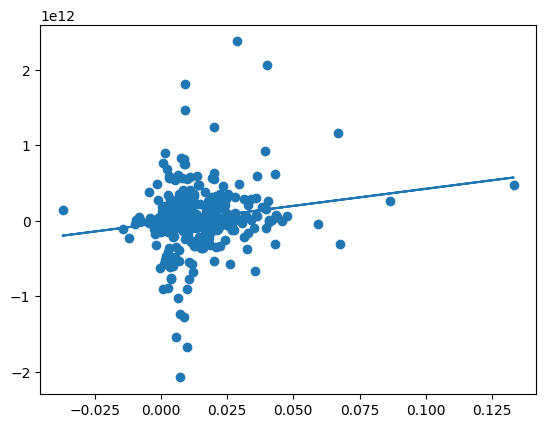

In [116]:
X_new_with_const = sm.add_constant(data['ROE'])
y_predict= model.predict(X_new_with_const)

plt.plot(data['ROE'],y_predict)
plt.scatter(data['ROE'],data['target'])
plt.show()

In [103]:
# Dự đoán
X_new = np.linspace(0, 12, 10)  # Tạo giá trị mới để dự đoán
X_new_with_const = sm.add_constant(X_new)
y_predict= model.predict(X_new_with_const)
y_True=3*X_new+2

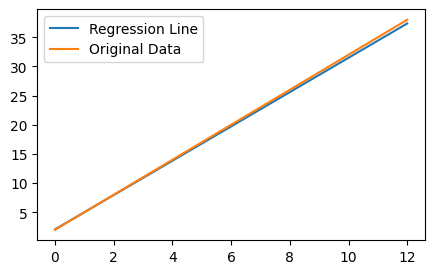

In [7]:
plt.figure(figsize=(5,3))
plt.plot(X_new,y_predict,label='Regression Line')
plt.plot(X_new,y_True,label='Original Data')
plt.legend()
plt.show()

# 8. Finnal model

In [ ]:
x= 2
y =3
